In [1]:
import torch
import torchvision

# Data Loading

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

**Define Transformations**

We convert the images to PyTorch Tensors and normalize them.

Normalization uses the mean and standard deviation calculated across the entire MNIST training set.

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

Define batch size for the DataLoader

The batch size determines how many samples are processed at once.

In [4]:
batch_size = 64

**Download and Load Datasets**

In [5]:
print("Downloading MNIST training data...")
train_data = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)


100%|██████████| 9.91M/9.91M [00:00<00:00, 55.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.70MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 16.1MB/s]


In [6]:
print("Downloading MNIST testing data...")
test_data = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

**Create DataLoader Instances**

In [7]:
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True  # Important: shuffle the training data every epoch
)

test_loader = DataLoader(
    test_data,
    batch_size=1000, # Using a larger batch size for testing/inference is common
    shuffle=False
)

In [8]:
print(f"\nTraining dataset size: {len(train_data)}")
print(f"Testing dataset size: {len(test_data)}")
print(f"Number of batches in training loader: {len(train_loader)}")

# Example of checking the first batch
first_images, first_labels = next(iter(train_loader))
print(f"Shape of one image batch: {first_images.shape}")
print(f"Shape of one label batch: {first_labels.shape}")


Training dataset size: 60000
Testing dataset size: 10000
Number of batches in training loader: 938
Shape of one image batch: torch.Size([64, 1, 28, 28])
Shape of one label batch: torch.Size([64])


# Defining the CNN Architecture

In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.dropout = nn.Dropout2d(0.25)

        self.fc1 = nn.Linear(1600, 128)

        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)

        x = self.dropout(x)
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)

        return x


In [23]:
model=Net()

In [24]:
print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


# Training the Model

In [25]:
import torch.optim as optim

**Device Setup (GPU Acceleration)**

In [26]:
use_cuda= torch.cuda.is_available()

In [27]:
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Using device: {device}")

Using device: cuda


Move the model to selected device

In [28]:
model = model.to(device)

Optimizer(Stochastic Gradient Decent)

In [29]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

Loss function(Cross-Entropy Loss)

In [30]:
criterion = nn.CrossEntropyLoss()

**Define Training Function**

In [31]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        output = model(data)

        loss = criterion(output, target)

        loss.backward()

        optimizer.step()

        if batch_idx % 100 == 0:

            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)] Loss: {loss.item():.6f}')

**Defining Testing Function**

In [32]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)

            test_loss += criterion(output, target).item()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')

    return accuracy

**Running the Training Loop**

In [33]:
#Training Hyperparameters
num_epochs = 10
best_accuracy = 0.0

accuracy_history = []

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    current_accuracy = test(model, device, test_loader)
    accuracy_history.append(current_accuracy)

    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy

print(f"\nTraining Complete. Final Best Accuracy: {best_accuracy:.2f}%")

/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:1531: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Epoch: 1 [0/60000 (0%)] Loss: 2.291146
Train Epoch: 1 [6400/60000 (11%)] Loss: 0.716890
Train Epoch: 1 [12800/60000 (21%)] Loss: 0.656572
Train Epoch: 1 [19200/60000 (32%)] Loss: 0.270934
Train Epoch: 1 [25600/60000 (43%)] Loss: 0.531591
Train Epoch: 1 [32000/60000 (53%)] Loss: 0.138959
Train Epoch: 1 [38400/60000 (64%)] Loss: 0.315415
Train Epoch: 1 [44800/60000 (75%)] Loss: 0.285327
Train Epoch: 1 [51200/60000 (85%)] Loss: 0.344743
Train Epoch: 1 [57600/60000 (96%)] Loss: 0.181012

Test set: Average loss: 0.0001, Accuracy: 9655/10000 (96.55%)

Train Epoch: 2 [0/60000 (0%)] Loss: 0.199756
Train Epoch: 2 [6400/60000 (11%)] Loss: 0.095299
Train Epoch: 2 [12800/60000 (21%)] Loss: 0.057239
Train Epoch: 2 [19200/60000 (32%)] Loss: 0.174884
Train Epoch: 2 [25600/60000 (43%)] Loss: 0.078389
Train Epoch: 2 [32000/60000 (53%)] Loss: 0.213482
Train Epoch: 2 [38400/60000 (64%)] Loss: 0.088413
Train Epoch: 2 [44800/60000 (75%)] Loss: 0.088948
Train Epoch: 2 [51200/60000 (85%)] Loss: 0.07223

# Evaluation and Demonstration

In [34]:
import matplotlib.pyplot as plt
import numpy as np

**Visualize Training Curve**

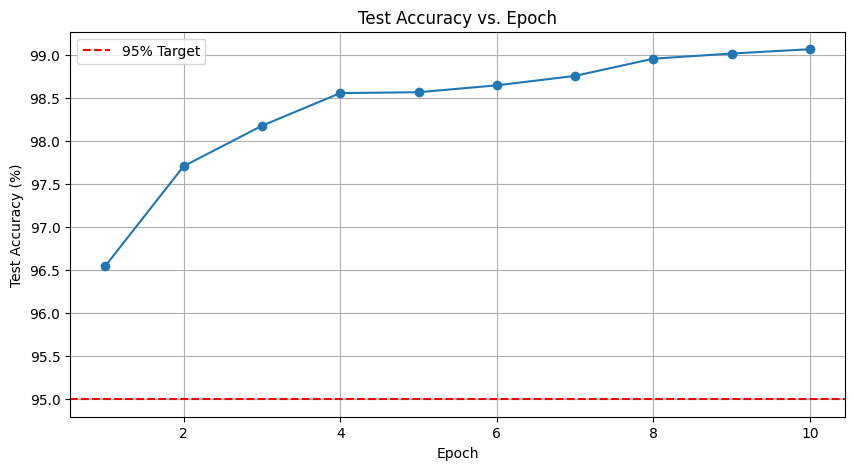

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, len(accuracy_history) + 1), accuracy_history, marker='o', linestyle='-')
plt.title('Test Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.grid(True)
plt.axhline(y=95, color='r', linestyle='--', label='95% Target')
plt.legend()
plt.show()

**Confusion Matrix**

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

In [37]:
def get_predictions(model, device, test_loader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            all_preds.extend(pred.cpu().tolist())
            all_targets.extend(target.cpu().tolist())
    return all_targets, all_preds

/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:1531: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


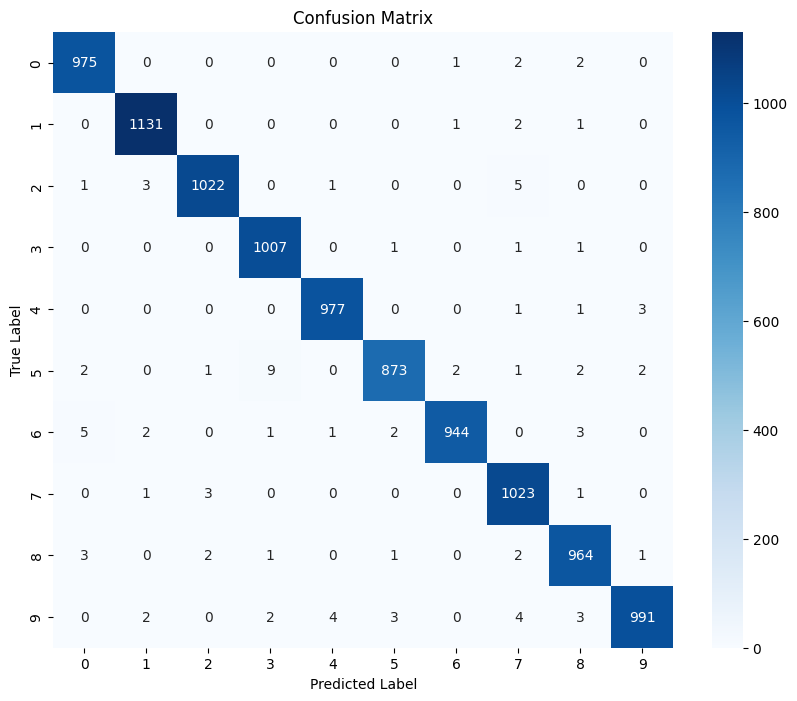

In [38]:
targets, preds = get_predictions(model, device, test_loader)
cm = confusion_matrix(targets, preds)
plt.figure(figsize=(10, 8))
df_cm = pd.DataFrame(cm, index=[i for i in range(10)], columns=[i for i in range(10)])
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**Demonstrate model interface**

/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:1531: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


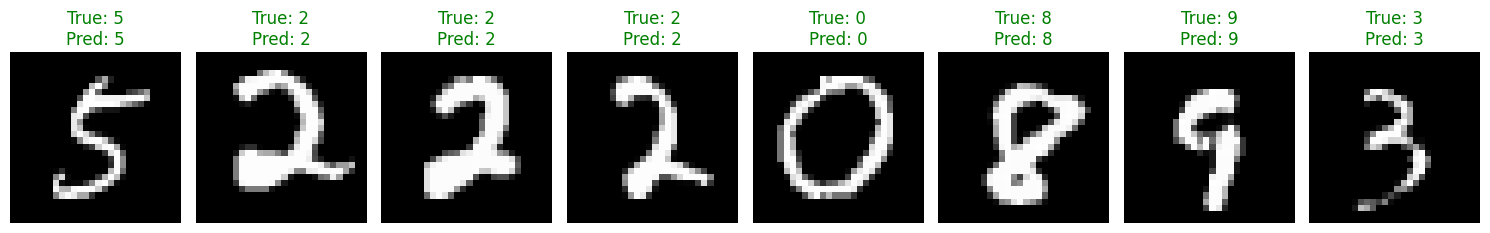

In [39]:

def display_sample_inference(model, device, test_data, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    model.eval()

    with torch.no_grad():
        for i in range(num_samples):
            idx = np.random.randint(0, len(test_data))
            image, true_label = test_data[idx]

            data = image.unsqueeze(0).to(device)

            output = model(data)
            pred_label = output.argmax(dim=1).item()

            display_image = image.cpu().squeeze().numpy() * 0.3081 + 0.1307

            axes[i].imshow(display_image, cmap='gray')
            axes[i].set_title(f"True: {true_label}\nPred: {pred_label}",
                              color='green' if pred_label == true_label else 'red')
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

display_sample_inference(model, device, test_data, num_samples=8)